In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from shapely.geometry import Point
import matplotlib.pyplot as plt
import rasterio.mask
import fiona
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.warp import reproject, Resampling
from natsort import natsorted
import earthpy.spatial as es
import gdal
from osgeo import osr,gdal_array
import xarray as xr
import netCDF4
import pandas as pd
import numpy as np
import geopandas
import rasterio
import pycrs
import os

file_dir=r'C:/Users/Mark.Rademaker/PycharmProjects/InternshipNaturalis/trait-geo-diverse-dl/extended model extra observations and variables'

#### Part 1. Stacking Bioclim rasters
- open and stack the raster files

In [ ]:
#BIOCLIM dataset
#create list of raster file locations and a list containing only the names of each raster
list_bioclim_files=[]
names_bioclim=[]

for root, dirs, files in os.walk(file_dir+"/data/GIS/wc5"):
    for file in files:
        if file.endswith('.tif') and "stacked" not in file:
            list_bioclim_files.append(file_dir+"/data/GIS/wc5/"+file)
            name=file.replace(".tif","")
            names_bioclim.append(name)
            names_bioclim=natsorted(names_bioclim,key=lambda y: y.lower())
print(names_bioclim)
#Stack ENVIREM dataset
#es.stack(list_envirem_files, file_dir+'/data/GIS/env_stacked/BIOCLIM_stacked.tif')  

#### Part 2. Stacking ENVIREM rasters
- open and stack the raster files

In [ ]:
#ENVIREM dataset
#create list of raster file locations and a list containing only the names of each raster
list_envirem_files=[]
names_envirem=[]

for root, dirs, files in os.walk(file_dir+"/data/GIS/5_deg"):
    for file in files:
        if file.endswith('.tif') and "stacked" not in file:
            list_envirem_files.append(file_dir+"/data/GIS/5_deg/"+file)
            name=file.replace(".tif","")
            names_envirem.append(name)
            names_envirem=natsorted(names_envirem,key=lambda y: y.lower())
print(names_envirem)
#Stack ENVIREM dataset
#es.stack(list_envirem_files, file_dir+'/data/GIS/env_stacked/ENVIREM_stacked.tif')

#### Part 3. Stacking Soil rasters
- the rasters are not yet in the right resolution (5 deg) and therefore have to be resampled before stacking

In [ ]:
#source raster
source_raster=rasterio.open(file_dir+'/data/GIS/5_deg/Aspect_5deg.tif')
source_profile=source_raster.profile

#raster to adapt
infile=file_dir+'/data/GIS/historic_1_deg/Global_Biomass_1950-2010_1296/data/historical_global_1-degree_forest_biomass.nc4'
dataset=netCDF4.Dataset(infile)

variable_list=[]

for item in dataset.variables.keys():
    variable_list.append(item)
print(variable_list)

for item in dataset.variables.keys():
    print("variable %s"%item)
    try:
        with rasterio.open(r'NETCDF:'+file_dir+'/data/GIS/historic_1_deg/Global_Biomass_1950-2010_1296/data/historical_global_1-degree_forest_biomass.nc4:%s'%item) as src:
        # Register GDAL format drivers and configuration options with a
        # context manager.
            for i in range(1,14):
                print("band %s"%i)
                array=src.read(i)
                with rasterio.Env():

                    # Write an array as a raster band to a new 8-bit file. For
                    # the new file's profile, we start with the profile of the source
                    profile = source_profile

                    # And then change the band count to 1, set the
                    # dtype to uint8, and specify LZW compression.

                    with rasterio.open(file_dir+'/data/GIS/historic_1_deg/{}_{}.tif'.format(item,i), 'w', **profile) as dst:
                        dst.write(array.astype(rasterio.float32), 1)

            # At the end of the ``with rasterio.Env()`` block, context
            # manager exits and all drivers are de-registered.
    except:
        pass

#### Part X. Create  ecobiomes raster
- the file is still in shapefile format, must be transformed into raster in right resolution (5 deg)

In [3]:
import geopandas as gpd
import rasterio
import fiona
from rasterio import features
import os
from datetime import datetime as dt

In [21]:
import geopandas as gpd
import rasterio
from rasterio import features

shp_fn=file_dir+'/data/GIS/tnc/tnc_terr_ecoregions.shp'
rst_fn =file_dir+'/data/GIS/5_deg/Aspect_5deg.tif'
out_fn =file_dir+'/data/GIS/tnc/ecoregions.tif'
df=gpd.read_file(file_dir+'/data/GIS/tnc/tnc_terr_ecoregions.shp')

rst = rasterio.open(rst_fn)
meta = rst.meta.copy()


src=rasterio.open(rst_fn)

with rasterio.open(out_fn, 'w', **meta) as out:
    out_arr = src.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(df.geometry, df.WWF_MHTNUM))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform,all_touched=True)
    out.write_band(1, burned)

C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 4320, 'height': 1800, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0), 'tiled': False, 'interleave': 'band'}

C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


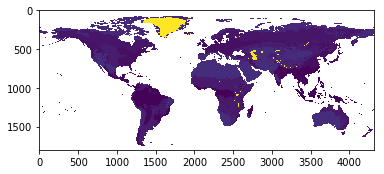

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 4320, 'height': 1800, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0), 'tiled': False, 'interleave': 'band'}

C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=nan,
  dtype=float32)

Text(0.5, 1.0, 'ecoregions map')

<function matplotlib.pyplot.show>

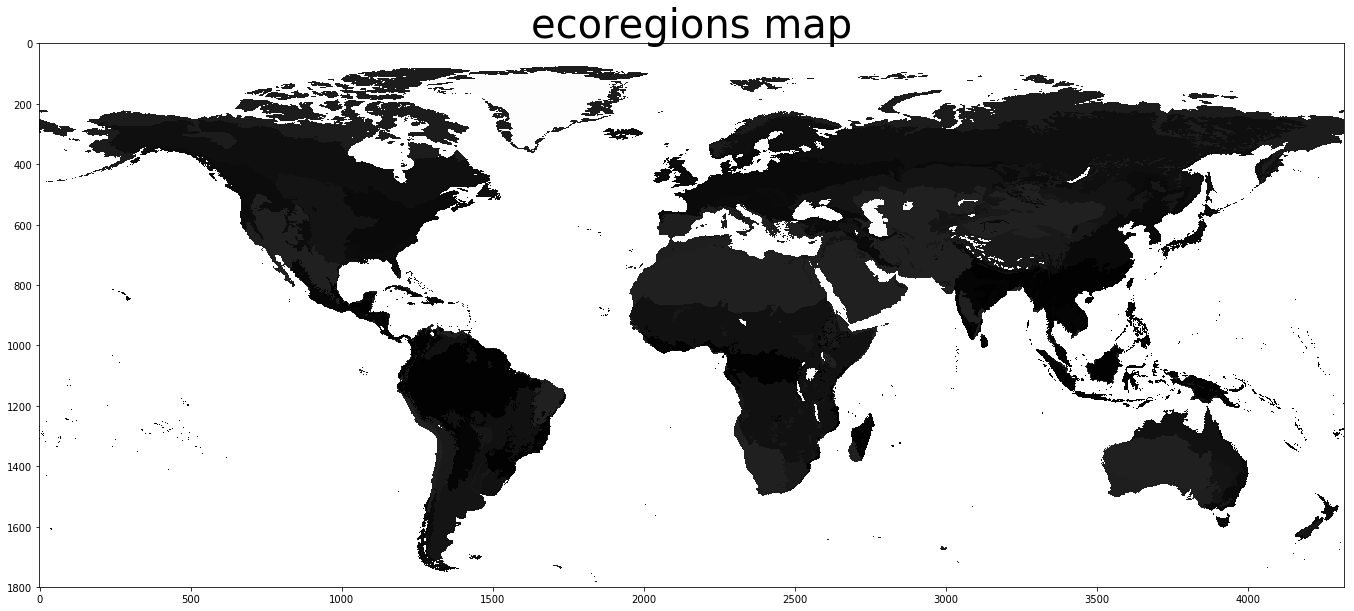

In [35]:
raster=rasterio.open(out_fn)
raster.profile
band=raster.read(1)
show(band)

clipped = rasterio.open(out_fn)
clipped.profile
array = clipped.read(1)
array_data = clipped.read(1,masked=True)
array_data
array_meta = clipped.profile

fig, ax = plt.subplots(figsize=(24, 10))
ax.imshow(array_data,cmap="gray",interpolation="none",vmin=0,vmax=100)
#spec=spec.replace("_"," ")
# Here you must set the spatial extent or else the data will not line up with your geopandas layer
ax.set_title('ecoregions map',fontsize=40)
plt.show
#spec=spec.replace(" ","_")
#plt.savefig(file_dir+'/results/DNN_global_predictions/%s_predicted_map_color.tif'%spec,dpi=300)

In [23]:
np.unique(band)

array([0.000000e+00, 2.220446e-16, 4.440892e-16, ...,          nan,
                nan,          nan], dtype=float32)

In [ ]:
list_historic_files=[]
names_historic=[]

##stack the rasters
for root, dirs, files in os.walk(file_dir+"/data/GIS/historic_1_deg"):
    for file in files:
        if file.endswith('.tif') and "time" not in file and "stacked" not in file:
            list_historic_files.append(file_dir+"/data/GIS/historic_1_deg/"+file)
            name=file.replace(".tif","")
            names_historic.append(name)
  
print(names_historic)
#es.stack(list_historic_files, file_dir+"/data/GIS/historic_1_deg/historic_forest_stacked.tif")

#### Part 4. Creating and stacking species occurrence rasters
- we make a copy of one of a single layered raster from the envirem dataset
- then all cell values are set to 0
- next the cell's in which occurrence records are located are identified and their values set to 1

In [ ]:
#access file with list of taxa names
taxa=pd.read_csv(file_dir+"/data/SQL_filtered_gbif/taxa_list.txt",header=None)
taxa.columns=["taxon"]

species_occ_dict={}

for i in taxa["taxon"]:
    taxon_data = pd.read_csv(file_dir+"/data/SQL_filtered_gbif/%s_filtered_data.csv"%i)
    #add species dataframe to dict
    species_occ_dict["%s"%i] = taxon_data  
    #check whether all species have been included and inspect dictionary
if len(species_occ_dict.keys())==len(taxa["taxon"]):
    print("All species dataframes now in dictionary")
else:
    print("Error: not all species dataframe included")

In [ ]:
pred_data=pd.read_csv(file_dir+'/data/GIS/world_locations_to_predict.csv')

long=pred_data["decimal_longitude"]
lati=pred_data["decimal_latitude"]
long=pd.Series.tolist(long)
lati=pd.Series.tolist(lati)

src = rasterio.open(file_dir+'/data/GIS/5_deg/Aspect_5deg.tif')
band= src.read(1,masked=True)
rasterio.plot.show(band)

new_band = band.copy()

#set raster cell mask values of land area to 0 (to differentiate it from the sea)
for i in range(0,len(pred_data)):
    row,col=src.index(long[i],lati[i])
    new_band[row,col]=0

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(new_band,cmap="gray")
ax.set_title("land map",
         fontsize=20)
plt.show()



profile = src.profile
print(profile)

In [ ]:
for key in species_occ_dict:
    new_band = band.copy()
    
    #lon_lat presence points
    presence_data = species_occ_dict[key]
    presence_data["present/pseudo_absent"]=1
    spec = key
    long=presence_data["decimal_longitude"]
    lati=presence_data["decimal_latitude"]
    long=pd.Series.tolist(long)
    lati=pd.Series.tolist(lati)

    #set raster cell mask values of presence locations to 100
    for i in range(0,len(presence_data)):
        row,col=src.index(long[i],lati[i])
        new_band[row,col]=100
        
    rasterio.plot.show(new_band)
    # Register GDAL format drivers and configuration options with a
    # context manager.
    #with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source


    with rasterio.open(file_dir+'/data/GIS/spec_presence/%s_presence_map.tif'%spec, 'w', **profile) as dst:
        dst.write(new_band.astype(rasterio.float32), 1)

In [ ]:
####stacking them into a single raster
#species presence dataset
#create list of raster file locations and a list containing only the names of each raster
list_species_files=[]
names_species=[]

for root, dirs, files in os.walk(file_dir+"/data/GIS/spec_presence"):
    for file in files:
        if file.endswith('.tif') and "stacked" not in file:
            list_species_files.append(file_dir+"/data/GIS/spec_presence/"+file)
            name=file.replace(".tif","")
            names_species.append(name)
print(names_species)
#es.stack(list_species_files, file_dir+"/data/GIS/spec_presence/species_presence_stacked.tif")

In [ ]:

print(len(list_raster_locations))
stacked=rasterio.open(file_dir+"/data/GIS/spec_presence/species_presence_stacked.tif")

for i in range(1,len(list_raster_locations)):
    band = stacked.read(i,masked=True)
    plt.imshow(band,interpolation="none")
    plt.show()

#### Part 5. Stack into single raster file

In [ ]:
#Stack ENVIREM+BIOCLIM+HISTORIC+SPECIES dataset
list_variables=[]
list_names=[]
for item in list_bioclim_files:
    list_variables.append(item)   
for item in list_envirem_files:
    list_variables.append(item)
for item in list_historic_files:
    list_variables.append(item)
for item in list_species_files:
    list_variables.append(item)
    
es.stack(list_variables, file_dir+"/data/GIS/env_stacked/stacked_env_variables.tif")

for item in names_bioclim:
    list_names.append(item)   
for item in names_envirem:
    list_names.append(item)
for item in names_historic:
    list_names.append(item)
for item in names_species:
    list_names.append(item)
list_names

In [ ]:
###create dataset to predict on

 ###Dataset of world map including all locations with data-values (to later predict presence-pseudoabsence on)
    src=rasterio.open(file_dir+'/data/GIS/env_stacked/stacked_env_variables.tif')
    array=src.read_masks(1)
    
    r = gdal.Open(file_dir+'/data/GIS/env_stacked/stacked_env_variables.tif')
    (y_index, x_index) = np.nonzero(array > 0)
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = r.GetGeoTransform()
    x_coords = x_index * x_size + upper_left_x + (x_size / 2) #add half the cell size
    y_coords = y_index * y_size + upper_left_y + (y_size / 2) #to centre the point

    lon_lat_array=np.stack((x_coords,y_coords)).T

    lon=[]
    lat=[]

    for item in lon_lat_array:
        longitude=item[0]
        latitude=item[1]
        lon.append(longitude)
        lat.append(latitude)

    taxon=["%s"%spec]*len(lon)

    data_to_pred=pd.DataFrame({"decimal_longitude":lon,"decimal_latitude":lat})
    print(len(data_to_pred), "number of points to predict")
    data_to_pred.to_csv(file_dir + "/data/GIS/world_locations_to_predict2.csv")
    


In [ ]:
###extract raster values at world locations to predict
data=pd.read_csv(file_dir + "/data/GIS/world_locations_to_predict.csv")
src = rasterio.open(file_dir+'/data/GIS/env_stacked/stacked_env_variables.tif')

lon = data["decimal_longitude"]
lat = data["decimal_latitude"]
lat = pd.Series.tolist(lat)
lon = pd.Series.tolist(lon)

for i in range(1, 348):
    array = src.read(i)
    band_name = list_names[i]
    data[band_name] = None
    print("processing band %s" % i)
    for j in range(0, len(data)):
        # What is the corresponding row and column in our image?
        row, col = src.index(lon[j], lat[j])  # spatial --> image coordinates
        # print(f'row,col=\t\t({row},{col})')
        # What is the value?
        value = array[row, col]
        data[band_name][j] = value
data.to_csv(file_dir + "/data/GIS/world_env_dataframe.csv")




